<a href="https://colab.research.google.com/github/VKSi/2020_12_GB_RecommendationSystems/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install implicit

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/RecSys/capstone/'
OBJECTS_PATH = PATH + 'objects/'
DATA_PATH = PATH + 'raw_data/'

In [ ]:
def save_obj(obj, name: str):
    path = OBJECTS_PATH + name + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    return path

def load_obj(name: str):
    with open(OBJECTS_PATH + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
# Функции из модуля metrics
def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    

    bought_list = bought_list  # Тут нет [:k] !!
    
    if k < len(recommended_list):
        recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):
    # your_code
    # Лучше считать через скалярное произведение, а не цикл

    return precision


def recall(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def recall_at_k(recommended_list, bought_list, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    if k < len(recommended_list):
        recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)

    return recall


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):
    # your_code

    return recall

In [ ]:
# Функции из модуля utils

def prefilter_items(data, take_n_popular=5000, item_features=None):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
    # data = data[~data['item_id'].isin(top_popular)]                                                 # !!! НЕ ДЕЛАЕМ !!! 

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
    # data = data[~data['item_id'].isin(top_notpopular)]                                                 # !!! НЕ ДЕЛАЕМ !!!

    # Уберем товары, которые не продавались за последние 12 месяцев

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features.\
                                        groupby('department')['item_id'].nunique().\
                                        sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        # data = data[~data['item_id'].isin(items_in_rare_departments)]                                                 # !!! НЕ ДЕЛАЕМ !!!


    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    # data = data[data['price'] > 2]                                                 # !!! НЕ ДЕЛАЕМ !!!

    # Уберем слишком дорогие товарыs
    data = data[data['price'] < 50]

    # Возбмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()
    
    # Заведем фиктивный item_id (если юзер не покупал товары из топ-5000, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
    
    # ...

    return data


def postfilter_items(user_id, recommednations):
    pass

In [ ]:
# Функции из модуля recommenders

import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

class MainRecommender:
    """Рекоммендации, которые можно получить из ALS

    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, weighting=True):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          values='quantity',  # Можно пробовать другие варианты
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads,
                                        use_gpu=False)  # Добавлено, чтобы избежать ошибки с CUDA
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                        user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        recalculate_user=True)]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendations(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendations(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""

        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = [rec[0] for rec in similar_users]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [ ]:
data = pd.read_csv(DATA_PATH + 'retail_train.csv')
item_features = pd.read_csv(DATA_PATH + 'product.csv')
user_features = pd.read_csv(DATA_PATH + 'hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


In [ ]:
# !!! Разбивка сделана не так как в методичке !!! В части data_val_lvl_1 взят весь остаток, data_train_lvl_2 считается отдельно

val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]

data_train_lvl_2 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


Сделаем модель минимальным предварительным фильтром (см код фильтра в классе)

In [ ]:
train_users = set(data_train_lvl_1['user_id'].unique())
val_users = set(data_val_lvl_1['user_id'].unique())
new_users = val_users - train_users
print(f'train_users: {len(train_users)}')
print(f'val_users: {len(val_users)}')
print(f'new_users: {len(new_users)}')

train_users: 2498
val_users: 2280
new_users: 1


In [ ]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=30000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decreased # items from 83685 to 30001


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
train_users = set(data_train_lvl_1['user_id'].unique())
val_users = set(data_val_lvl_1['user_id'].unique())
new_users = val_users - train_users
print(f'train_users: {len(train_users)}')
print(f'val_users: {len(val_users)}')
print(f'new_users: {len(new_users)}')

train_users: 2498
val_users: 2280
new_users: 1


In [ ]:
# recommender = MainRecommender(data_train_lvl_1)

In [ ]:
# save_obj(recommender, 'recommender_min_prefilter_30000')

'gdrive/My Drive/AI/GB/RecSys/capstone/objects/recommender_min_prefilter_30000.pkl'

In [ ]:
recommender = load_obj('recommender_min_prefilter_30000')

In [ ]:
recommender.get_als_recommendations(2375, N=5)

[981760, 1082185, 923746, 1098066, 1037863]

In [ ]:
recommender.get_own_recommendations(2375, N=5)

[948640, 5565086, 1069256, 824738, 1335640]

In [ ]:
recommender.get_similar_items_recommendations(2375, N=5)

[820352, 889731, 1046545, 1055646, 9527160]

In [ ]:
recommender.get_similar_users_recommendations(2375, N=5)

[1093490, 909618, 985605, 5585068, 979674]

# Отбор первого уровня


In [ ]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
actual_users = set(result_lvl_1['user_id'].unique())
predicted_users = set(data_train_lvl_1['user_id'].unique())
new_users_1 = actual_users - predicted_users
print(f'actual_users: {len(actual_users)}')
print(f'predicted_users: {len(predicted_users)}')
print(f'new_users_1: {len(new_users_1)}')

actual_users: 2280
predicted_users: 2498
new_users_1: 1


In [ ]:
k = 50

Напишем полезные функции для автоматизации дальнейшей работы

In [ ]:
def get_bought_list(actual_data, user_id):
  return actual_data.loc[actual_data['user_id'] == user_id, 'actual'].values[0]

def get_recommended_list(func_name: str, user_id, N):
  return eval(f'recommender.get_{func_name}_recommendations({user_id}, {N})')

def total_recall_at_k(actual_data, k, N, func_name: str):
  rc = []
  for uid in set(recommender.id_to_userid.values()):
    if uid not in actual_data['user_id'].values:
      continue
    rl = get_recommended_list(func_name=func_name, user_id=uid, N=N)
    bl = get_bought_list(actual_data=actual_data, user_id=uid)
    rc.append(recall_at_k(rl, bl, k))
  return np.mean(rc), np.std(rc)

In [ ]:
to_count = result_lvl_1['user_id'].isin(predicted_users)

In [ ]:
print(f'Среднее значение метрики recall_at_k для k = {k}: ')
print(f'Рекомендация \t Среднее значение \t Стандартное отклонение')
for fn in ['als', 'own', 'similar_items']:  # , 'similar_users'
  m, s = total_recall_at_k(actual_data=result_lvl_1[to_count], k=k, N=k, func_name=fn)
  print(f'{fn} \t\t\t {m:.3f} \t\t\t {s:.5f}')

Среднее значение метрики recall_at_k для k = 50: 
Рекомендация 	 Среднее значение 	 Стандартное отклонени
als 			 0.070 			 0.06630
own 			 0.045 			 0.06956
similar_items 			 0.040 			 0.05338


In [ ]:
methods = ['als', 'own', 'similar_items']  # , 'similar_users'
df = pd.DataFrame(columns=methods)
for k in [20, 50, 100, 200, 1000, 2000, 5000]:
  print(f'k: {k}')
  for fn in methods:
    m, s = total_recall_at_k(actual_data=result_lvl_1[to_count], k=k, N=k, func_name=fn)
    df.loc[k, fn] = m
    print(f'\t method: {fn}, metric: {m:.3f}')
  print(df.tail(1))
  print('='*50)
  df.to_csv(OBJECTS_PATH + 'total_recall.csv')

k: 20
	 method: als, metric: 0.043
	 method: own, metric: 0.026
	 method: similar_items, metric: 0.020
          als        own similar_items
20  0.0430812  0.0261389      0.019969
k: 50
	 method: als, metric: 0.070
	 method: own, metric: 0.045
	 method: similar_items, metric: 0.040
          als        own similar_items
50  0.0701462  0.0447899     0.0399609
k: 100
	 method: als, metric: 0.100
	 method: own, metric: 0.072
	 method: similar_items, metric: 0.064
           als        own similar_items
100  0.0998128  0.0717059     0.0638613
k: 200
	 method: als, metric: 0.139
	 method: own, metric: 0.122
	 method: similar_items, metric: 0.105
          als       own similar_items
200  0.139412  0.122365      0.105033
k: 1000
	 method: als, metric: 0.300
	 method: own, metric: 0.371
	 method: similar_items, metric: 0.298
           als       own similar_items
1000  0.300083  0.371381      0.298406
k: 2000
	 method: als, metric: 0.401
	 method: own, metric: 0.474
	 method: similar_items, 

In [ ]:
df.to_csv(PATH + 'total_recall.csv')
df

,als,own,similar_items
20,0.0430812,0.0261389,0.019969
50,0.0701462,0.0447899,0.0399609
100,0.0998128,0.0717059,0.0638613
200,0.139412,0.122365,0.105033
1000,0.300083,0.371381,0.298406
2000,0.400627,0.473847,0.406168
5000,0.565785,0.620462,0.576508


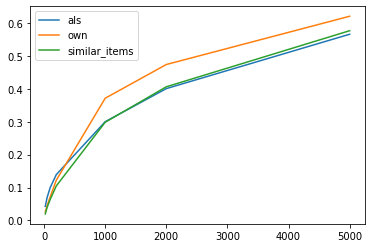

In [ ]:
df.plot()
plt.show()

In [ ]:
def prepare_lvl_1_candidates_table(recommender, actual_data, N, candidates_table_name):
  candidates = pd.DataFrame(actual_data['user_id'].unique())
  candidates.columns = ['user_id']
  candidates = candidates.sort_values(by='user_id', ascending=True)
  users = candidates.user_id.values
  
  top_rec = recommender.overall_top_purchases
  candidates[f'top_{N}'] = candidates['user_id'].apply(lambda x: recommender.overall_top_purchases[:N])

  for func_name in ['als', 'own', 'similar_items']:
    i = 0
    for uid in users:
      i += 1
      try:
        candidates.loc[candidates.user_id == uid, f'{func_name}_{N}'] = \
              candidates.loc[candidates.user_id == uid, 'user_id'].apply(lambda x: get_recommended_list(func_name=func_name, user_id=x, N=N))
      except:
        candidates.loc[candidates.user_id == uid, f'{func_name}_{N}'] = np.nan
      if i % 300 == 0:
        print(i)
    # candidates.to_csv(OBJECTS_PATH + f'candidates_{candidates_table_name}.csv')
    save_obj(candidates, f'candidates_{candidates_table_name}_obj')
    print(f'{func_name} сохранено')
  
  return candidates


In [ ]:
candidates_df = prepare_lvl_1_candidates_table(recommender=recommender, actual_data=data_val_lvl_1, N=1000, candidates_table_name='model_0_step_0')

300
600
900
1200
1500
1800
2100
als сохранено
300
600
900
1200
1500
1800
2100
own сохранено
300
600
900
1200
1500
1800
2100
similar_items сохранено


In [ ]:
candidates_df.isna().sum()

user_id               0
top_1000              0
als_1000              1
own_1000              1
similar_items_1000    0
dtype: int64

In [ ]:
candidates_df[candidates_df['als_1000'].isna()]

,user_id,top_1000,als_1000,own_1000,similar_items_1000
1903,1984,"[1082185, 6534178, 1029743, 995242, 1106523, 9...",NaN,NaN,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."


In [ ]:
candidates_df.head()

,user_id,top_1000,als_1000,own_1000,similar_items_1000
877,1,"[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 1006546, 1075074, 5577022, 9858900, ...","[1049998, 852662, 896666, 1087895, 900875, 938...","[941313, 840361, 1077555, 844179, 1006414, 557..."
1769,2,"[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 1098066, 951590, 981760, 1127831, 82...","[242044, 9651582, 73207, 1107760, 7463018, 238...","[8090509, 979098, 5592931, 7025275, 985999, 93..."
2178,3,"[1082185, 6534178, 1029743, 995242, 1106523, 9...","[826249, 1098066, 883404, 5568378, 1044078, 98...","[7443137, 835476, 6632283, 1011504, 10285454, ...","[1053690, 1092026, 960318, 892008, 925178, 979..."
1629,4,"[1082185, 6534178, 1029743, 995242, 1106523, 9...","[951590, 883932, 826249, 8090521, 1137346, 109...","[6391541, 1013868, 943030, 979674, 891423, 104...","[835530, 6391551, 8019276, 7138817, 8069350, 1..."
917,6,"[1082185, 6534178, 1029743, 995242, 1106523, 9...","[1082185, 878996, 1037863, 863632, 981760, 102...","[1405491, 876626, 998519, 849618, 919815, 1126...","[840361, 874149, 882138, 845208, 948650, 70252..."


In [ ]:
def get_ind(itms, x, N):
  if x in itms:
    return itms.index(x)
  else:
    return N*1.5


def mix_values(candidates, user_id, N_used, N_return):
  cr = candidates[candidates.user_id == user_id]
  items = set()
  cols = cr.columns[1:]
  for col in cr.columns[1:]:
    if type(cr[col].values[0]) == type(np.nan):
      continue
    else:
      val = cr[col].values[0]
      items = items.union(set(val))

  mix_table = pd.DataFrame(columns = cr.columns[1:])
  mix_table['item_id'] = list(items)

  for col in cr.columns[1:]:
    if type(cr[col].values[0]) == type(np.nan):
      val = []
    else:
      val = cr[col].values[0]
    
    mix_table[col] = mix_table['item_id'].apply(lambda x: get_ind(val, x, N_used))

  a =  mix_table.drop(columns='item_id').sum(axis='columns')
  mix_table['mix'] = a

  mix_table = mix_table[['item_id', 'mix']].sort_values(by='mix', ascending=True).head(N_return)

  return mix_table.item_id.values


def get_mix(candidates, N_used, N_return):
  cand = candidates.sort_values(by='user_id', ascending=True).copy(deep=True)
  users = cand.user_id.values
  cand['mix'] = 0

  i = 0
  for uid in users:
    i += 1
    cand.loc[cand.user_id == uid, 'mix'] = \
            cand.loc[cand.user_id == uid, 'user_id'].apply(lambda x: mix_values(cand.drop(columns=['mix']), x, N_used, N_return))
    if i % 100 == 0:
      print(i)

  return cand 

In [ ]:
candidates_df_mix = get_mix(candidates_df, 1000, 500)
save_obj(candidates_df_mix, f'candidates_model_0_mix_obj')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


'gdrive/My Drive/AI/GB/RecSys/capstone/objects/candidates_model_0_mix_obj.pkl'

In [ ]:
predicted_users_mix = set(candidates_df_mix['user_id'].unique())
len(predicted_users_mix)

2280

In [ ]:
actual_users - predicted_users_mix

set()

Видно, что "холодные" юзеры тоже заполнились

In [ ]:
# Определим функцию для расчета precision_at_k по готовому предсказанию
def total_precision_at_k_pre(actual_data, k, recommendations_table):
  pr = []
  for uid in actual_data['user_id'].values:
    if uid == 1984:
      continue
    rl = recommendations_table.loc[recommendations_table.user_id == uid, 'candidates'].values[0]
    bl = get_bought_list(actual_data, user_id=uid)
    pr.append(precision_at_k(recommended_list=rl, bought_list=bl, k=k))
  return np.mean(pr), np.std(pr)

# Определим функцию для расчета recall_at_k по готовому предсказанию
def total_recall_at_k_pre(actual_data, k, recommendations_table):
  pr = []
  for uid in actual_data['user_id'].values:
    if uid == 1984:
      continue
    rl = recommendations_table.loc[recommendations_table.user_id == uid, 'candidates'].values[0]
    bl = get_bought_list(actual_data, user_id=uid)
    pr.append(recall_at_k(recommended_list=rl, bought_list=bl, k=k))
  return np.mean(pr), np.std(pr)

In [ ]:
for col in candidates_df_mix.columns[1:]:
  data = candidates_df_mix[['user_id', col]].rename(columns={col:'candidates'})
  mean, std = total_recall_at_k_pre(actual_data = result_lvl_1, k=500, recommendations_table=data)
  print(col, mean, ' +- ', std)

top_1000 0.2320115957245607  +-  0.12833677432302826
als_1000 0.2196147059647217  +-  0.12790176594062908
own_1000 0.2521933612200731  +-  0.14294008193338748
similar_items_1000 0.19989117417736563  +-  0.1270595684190121
mix 0.28974401692444834  +-  0.1334389227740078


Recall хороший, но для этого оставлено много товаров

In [ ]:
for col in candidates_df_mix.columns[1:]:
  data = candidates_df_mix[['user_id', col]].rename(columns={col:'candidates'})
  mean, std = total_precision_at_k_pre(actual_data = result_lvl_1, k=5, recommendations_table=data)
  print(col, mean, ' +- ', std)

top_1000 0.2840719613865731  +-  0.24005613300552042
als_1000 0.25730583589293554  +-  0.2551065628654374
own_1000 0.1601579640193067  +-  0.2074335359680525
similar_items_1000 0.10978499341816587  +-  0.1619481477680439
mix 0.2268538832821413  +-  0.2311014342269853


При этом precision не намного лучше, чем для модели со 100 товарами

In [ ]:
users_lvl_2 = candidates_df_mix[['user_id', 'mix']].rename(columns={'mix':'candidates'})
save_obj(users_lvl_2, 'users_lvl_2_obj')

'gdrive/My Drive/AI/GB/RecSys/capstone/objects/users_lvl_2_obj.pkl'

# Второй уровень

In [ ]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [ ]:
df.head()

,user_id,item_id
0,1,1127831
1,1,878996
2,1,1082185
3,1,860776
4,1,981760


In [ ]:
df.user_id.nunique()

2280

In [ ]:
df_train = df[df.user_id.isin(data_train_lvl_2.user_id.values)]

In [ ]:
df_train.user_id.nunique()

2154

In [ ]:
data_train_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


In [ ]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df_train.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [ ]:
targets_lvl_2.head()

,user_id,item_id,target
0,1,1127831,0.0
1,1,878996,0.0
2,1,1082185,1.0
3,1,1082185,1.0
4,1,1082185,1.0


In [ ]:
targets_lvl_2['target'].mean()

0.054643270921125246

Таблица, полученная из первого уровня, готова. Теперь нужно добавить фитчи. Пока без генерации

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1,1127831,0.0,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,1,878996,0.0,2,PRODUCE,National,GRAPES,GRAPES RED,18 LB,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown


In [ ]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [ ]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [ ]:
y_train.mean()

target    0.054643
dtype: float64

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, weght='balanced')
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
train_preds

array([0.10062602, 0.05366087, 0.71772169, ..., 0.03370649, 0.03044229,
       0.03304005])

In [ ]:
k = 5
targets_lvl_2_pred = targets_lvl_2.copy(deep=True)
targets_lvl_2_pred['predict_proba'] = train_preds
targets_lvl_2_pred = targets_lvl_2_pred[['user_id', 'item_id', 'predict_proba']]
users = targets_lvl_2_pred['user_id'].unique()
lvl_2_recommendations = pd.DataFrame(data = {'user_id': users})
lvl_2_recommendations['candidates'] = 0

def get_lvl_2_reccomendations(user_id, targets_lvl_2_pred):
  tdf = targets_lvl_2_pred[targets_lvl_2_pred['user_id']==user_id]
  tdf = tdf.drop(columns=['user_id'])
  tdf = tdf.groupby(['item_id']).max()
  tdf = tdf.sort_values(by='predict_proba', ascending=False)
  tdf = tdf.index[:k].tolist()
  return tdf

print(get_lvl_2_reccomendations(2027, targets_lvl_2_pred))
lvl_2_recommendations['candidates'] = lvl_2_recommendations['user_id'].apply(lambda x: get_lvl_2_reccomendations(x, targets_lvl_2_pred))

[1082185, 6534178, 1029743, 1106523, 995242]


In [ ]:
lvl_2_recommendations.head()

,user_id,candidates
0,1,"[1082185, 6534178, 1029743, 9655212, 981760]"
1,2,"[1082185, 6534178, 1029743, 1106523, 915041]"
2,4,"[1082185, 6534178, 1029743, 1106523, 995242]"
3,6,"[1082185, 1056212, 1098844, 6534178, 1029743]"
4,7,"[1082185, 6534178, 1029743, 981760, 995242]"


In [ ]:
lvl_2_recommendations[lvl_2_recommendations.user_id == 1984]

,user_id,candidates
1715,1984,"[1082185, 6534178, 1029743, 1106523, 995242]"


Результат на трейне 2-го уровня:

In [ ]:
result_lvl_1_train = result_lvl_1[result_lvl_1.user_id.isin(data_train_lvl_2.user_id.values)]
result_lvl_1_train.user_id.values

array([   1,    2,    4, ..., 2498, 2499, 2500])

In [ ]:
mean, std = total_precision_at_k_pre(actual_data = result_lvl_1_train, k=5, recommendations_table=lvl_2_recommendations)
print(mean, ' +- ', std)

0.3221551323734324  +-  0.2581807805786271


Посмотрим на валидационный сет

In [ ]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [ ]:
df_val = df[df.user_id.isin(data_val_lvl_2.user_id.values)]

Расчитаем рекоммендации второго уровня для валидационного набора данных

In [ ]:
targets_val_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_val_lvl_2['target'] = 1  # тут только покупки 
targets_val_lvl_2 = df_val.merge(targets_val_lvl_2, on=['user_id', 'item_id'], how='left')
targets_val_lvl_2['target'].fillna(0, inplace= True)

targets_val_lvl_2 = targets_val_lvl_2.merge(item_features, on='item_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_features, on='user_id', how='left')

X_val = targets_val_lvl_2.drop('target', axis=1)
X_val[cat_feats] = X_val[cat_feats].astype('category')

val_preds = lgb.predict_proba(X_val)[:, 1]

In [ ]:
k = 5
targets_val_lvl_2_pred = targets_val_lvl_2.copy(deep=True)
targets_val_lvl_2_pred['predict_proba'] = val_preds
targets_val_lvl_2_pred = targets_val_lvl_2_pred[['user_id', 'item_id', 'predict_proba']]
users = targets_val_lvl_2_pred['user_id'].unique()
val_lvl_2_recommendations = pd.DataFrame(data = {'user_id': users})
val_lvl_2_recommendations['candidates'] = 0

def get_lvl_2_reccomendations(user_id, targets_val_lvl_2_pred):
  tdf = targets_val_lvl_2_pred[targets_val_lvl_2_pred['user_id']==user_id]
  tdf = tdf.drop(columns=['user_id'])
  tdf = tdf.groupby(['item_id']).max()
  tdf = tdf.sort_values(by='predict_proba', ascending=False)
  tdf = tdf.index[:k].tolist()
  return tdf

print(get_lvl_2_reccomendations(2027, targets_val_lvl_2_pred))
val_lvl_2_recommendations['candidates'] = val_lvl_2_recommendations['user_id'].apply(lambda x: get_lvl_2_reccomendations(x, targets_val_lvl_2_pred))

[1082185, 6534178, 1029743, 1106523, 995242]


In [ ]:
mean, std = total_precision_at_k_pre(actual_data = result_lvl_2, k=5, recommendations_table=val_lvl_2_recommendations)
print(mean, ' +- ', std)

0.2112689857912788  +-  0.21690081694944555


Качество не лучше, чем для модели первого уровня. Чтобы увеличить качество, нужно поработать с фитчами

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 